In [254]:
import numpy as np
import pandas as pd

import talib
from datetime import datetime

from binance.client import Client


In [255]:
client = Client('JLCON0ZJ9v4zX595o2W1rlvSIhIercTu2ugNLCMPZ88QAt8zvSe2vY3LDiiRjKMB','JMnozKSUlep8mBrXCW1b7mAdHDl5qcYv3GDfNOquyifCdbD4QmGXILR9A5V0FgKf')
start_str = 'Jan 1, 2022'
end_str = ''
coin = 'BTC'
klines = client.get_historical_klines(symbol=f'{coin}USDT', interval=client.KLINE_INTERVAL_4HOUR, start_str=start_str)  ##craw dữ liệu
df = pd.DataFrame(klines)
df = df.iloc[:,:6] ## Chỉ lấy 6 cột đầu.
df.columns = ['time','open','high','low','close','volume']
df = df.astype(float) ## Dữ liệu đang ở dạng string nên cần chuyển qua float.
df['time'] = [datetime.fromtimestamp(ts / 1000) for ts in df['time']] ##chuyển định dạng timestamp sang thời gian chuẩn YY/MM/DD 00:00 UTC

df.tail()

,time,open,high,low,close,volume
2044,2022-12-07 23:00:00,16837.48,16850.24,16778.21,16815.73,31381.52031
2045,2022-12-08 03:00:00,16815.13,16865.81,16793.70,16836.64,21635.69423
2046,2022-12-08 07:00:00,16836.64,16890.01,16780.01,16834.32,36098.63764
2047,2022-12-08 11:00:00,16834.32,16851.00,16777.00,16825.55,29113.62581
2048,2022-12-08 15:00:00,16825.55,16846.34,16793.00,16823.98,18448.72874


In [256]:
open = df['open']
high = df['high']
low  = df['low']
close = df['close']
volume = df['volume']
df.dropna()
avg = (df['high'] + df['low']) / 2
diff = (df['high'] - df['low'])
##Overlap Studies
df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['BBANDS_upperband'] = (df['BBANDS_upperband'] - avg) / close
df['BBANDS_middleband'] = (df['BBANDS_middleband'] - avg) / close
df['BBANDS_lowerband'] = (df['BBANDS_lowerband'] - avg) / close
df['DEMA'] = (talib.DEMA(close, timeperiod=30) - avg) / close
df['EMA'] = (talib.EMA(close, timeperiod=30) - avg) / close
df['HT_TRENDLINE'] = (talib.HT_TRENDLINE(close) - avg) / close
df['KAMA'] = (talib.KAMA(close, timeperiod=30) - avg) / close
df['MA'] = (talib.MA(close, timeperiod=30, matype=0) - avg) / close
df['MIDPOINT'] = (talib.MIDPOINT(close, timeperiod=14) - avg) / close
df['SMA'] = (talib.SMA(close, timeperiod=30) - avg) / close
df['T3'] = (talib.T3(close, timeperiod=5, vfactor=0) - avg) / close
df['TEMA'] = (talib.TEMA(close, timeperiod=30) - avg) / close
df['TRIMA'] = (talib.TRIMA(close, timeperiod=30) - avg) / close
df['WMA'] = (talib.WMA(close, timeperiod=30) - avg) / close
df['LINEARREG'] = (talib.LINEARREG(close, timeperiod=14) - close) / close
df['LINEARREG_INTERCEPT'] = (talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close) / close

df['AD'] = talib.AD(high, low, close, volume) / close
df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10) / close
df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0) / close
df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
df['HT_PHASOR_inphase'] /= close
df['HT_PHASOR_quadrature'] /= close
df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14) / close
df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['MACD_macd'] /= close
df['MACD_macdsignal'] /= close
df['MACD_macdhist'] /= close
df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14) / close
df['MOM'] = talib.MOM(close, timeperiod=10) / close
df['OBV'] = talib.OBV(close, volume) / close
df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14) / close
df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1) / close
df['TRANGE'] = talib.TRANGE(high, low, close) / close

##Momentum Indicators
df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
df['BOP'] = talib.BOP(open, high, low, close)
df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
df['DX'] = talib.DX(high, low, close, timeperiod=14)

df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
df['RSI'] = talib.RSI(close, timeperiod=14)
df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
df['TRIX'] = talib.TRIX(close, timeperiod=30)
df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

df['ATR'] = talib.ATR(high, low, close, timeperiod=14)  # Chỉ báo về biên động thị trường
df['NATR'] = talib.NATR(high, low, close, timeperiod=14)

df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

df['BETA'] = talib.BETA(high, low, timeperiod=5)
df['CORREL'] = talib.CORREL(high, low, timeperiod=30)

df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
diff =pd.DataFrame.median(diff)
print(diff)
## Pattern Recognition

448.0400000000009


In [257]:
#Phân nhóm dữ liệu
pipdiff = diff  # for TP
SLTPRatio = 2   # pipdiff/Ratio gives SL


def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length

    for line in range(0, length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]
            value2 = open[line + 1] - high[line + i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff / SLTPRatio))):
                trendcat[line] = 1  # -1 downtrend
                break
            elif ((valueOpenLow <= (pipdiff / SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2  # uptrend
                break
            else:
                trendcat[line] = 0  # no clear trend

    return trendcat
df['mytarget'] = mytarget(16, df)




In [258]:
df.to_csv('target.csv',index =False)

In [259]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
    'MOM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',

    'ULTOSC',
    'WILLR',

    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])
df = df.dropna()
X = df[features]
y = df["mytarget"]


In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [261]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))


****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 50.6427%


In [262]:
train_index = int(0.8 * len(X))
X_train, X_test = X[:train_index], X[train_index:]
y_train, y_test = y[:train_index], y[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

C:\Users\DAD\AppData\Local\Temp\ipykernel_16264\1226467017.py:3: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



****Train Results****
Accuracy: 100.0000%
****Test Results****
Accuracy: 32.1337%


In [263]:
import joblib

##Save Model
# filename = 'mymodel1.sav'
# joblib.dump(model, filename)

#load the model from disk
loaded_model = joblib.load('mymodel1.sav')

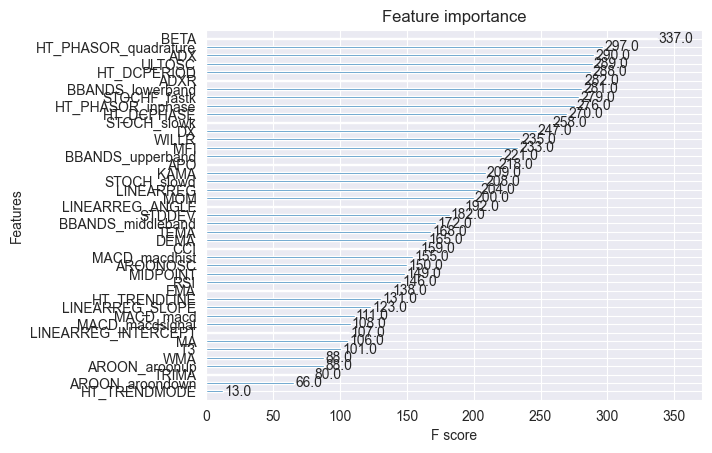

In [264]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()


In [269]:
balance = 100.00
tokenunit = 0.00
buy = True
buys =[]
sells = []


for i in range(len(df)) :
    X_stream  = df.iloc[[i]]
    X_model = X_stream[features]
    ModelPrediction = loaded_model.predict(X_model)
    #Buy Signal
    if ModelPrediction == 2 and buy == True :
         tokenunit = balance/df['close'].iloc[i]
         buys.append([df['time'].iloc[i],df['close'].iloc[i],balance])



         buy = False
    if ModelPrediction == 1 and buy == False :
        balance = tokenunit*df['close'].iloc[i]
        sells.append([df['time'].iloc[i],df['close'].iloc[i],balance])
        tokenunit=0

        buy = True

# print(f'num buys: {len(env.buys)}')
# print(f'num sells: {len(env.sells)}')
# print(f'ending balance: {env.balance_amount} {env.balance_unit}')
# plot_results(df,env.buys, env.sells)
# b.to_csv('his.csv',index=False)
# print(len(buys))
# print(balance)
for i in range(len(sells)) :
    profit = sells[i][2] - buys[i][2]
    print(buys[i],sells[i],"\n",profit)


[Timestamp('2022-01-18 19:00:00'), 41587.27, 100.0] [Timestamp('2022-01-19 03:00:00'), 42352.12, 101.83914452667848] 
 1.8391445266784814
[Timestamp('2022-01-19 11:00:00'), 41287.1, 101.83914452667848] [Timestamp('2022-01-20 19:00:00'), 43308.69, 106.82561720661212] 
 4.986472679933641
[Timestamp('2022-01-21 07:00:00'), 38465.65, 106.82561720661212] [Timestamp('2022-01-21 11:00:00'), 39134.55, 108.6832656630792] 
 1.857648456467075
[Timestamp('2022-01-22 23:00:00'), 34528.62, 108.6832656630792] [Timestamp('2022-01-24 03:00:00'), 36244.55, 114.08437570018023] 
 5.401110037101034
[Timestamp('2022-01-24 23:00:00'), 36066.4, 114.08437570018023] [Timestamp('2022-01-25 03:00:00'), 36660.35, 115.9631441646547] 
 1.8787684644744616
[Timestamp('2022-01-25 11:00:00'), 36044.01, 115.9631441646547] [Timestamp('2022-01-26 23:00:00'), 37579.9, 120.90450983099014] 
 4.941365666335443
[Timestamp('2022-01-27 07:00:00'), 35745.7, 120.90450983099014] [Timestamp('2022-01-28 03:00:00'), 37160.1, 125.688507

In [268]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=df['time'],
                                      open=df['open'],
                                      high=df['high'],
                                      low=df['low'],
                                      close=df['close'])])
fig.update_layout(xaxis_rangeslider_visible=False)
# fig.add_trace(go.Scatter(x=[buy[1] for buy in buys if buy[0] == 'BTC'],
#                          y=[buy[2] for buy in buys if buy[0] == 'BTC'],
#                          type='scatter',
#                          mode='markers',
#                          marker=dict(symbol='x',color='blue'),
#                          name='buys'))
#
# fig.add_trace(go.Scatter(x=[sell[1] for sell in sells if sell[0] == 'BTC'],
#                          y=[sell[2] for sell in sells if sell[0] == 'BTC'],
#                          type='scatter',
#                          mode='markers',
#                          marker=dict(symbol='x',color='orange'),
#                          name='sells'))

# fig.update_xaxes(range = [df['open'].iloc[0],df['open'].iloc[-1]])
# fig.update_yaxes(range = [min(df['low'])*.99,max(df['high'])*1.01])
fig.show()